In [120]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import *
from sklearn.model_selection import *
from scipy.stats import norm, skew

In [121]:
from bayes_opt import BayesianOptimization
from sklearn.model_selection import *
from sklearn.metrics import *
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
# from mlxtend.regressor import StackingCVRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
# from ngboost import NGBRegressor
# from catboost import CatBoostRegresor

In [122]:
fifa_train=pd.read_csv('FIFA_train.csv')
fifa_test=pd.read_csv('FIFA_test.csv')


선수 데이타 라벨
id : 선수 고유의 아이디
name : 이름
age : 나이
continent : 선수들의 국적이 포함되어 있는 대륙입니다
contract_until : 선수의 계약기간이 언제까지인지 나타내어 줍니다
 position : 선수가 선호하는 포지션입니다. ex) 공격수, 수비수 등
 prefer_foot : 선수가 선호하는 발입니다. ex) 오른발
 reputation : 선수가 유명한 정도입니다. ex) 높은 수치일 수록 유명한 선수
 stat_overall : 선수의 현재 능력치 입니다.
 stat_potential : 선수가 경험 및 노력을 통해 발전할 수 있는 정도입니다.
 stat_skill_moves : 선수의 개인기 능력치 입니다.
 value : FIFA가 선정한 선수의 이적 시장 가격 (단위 : 유로) 입니다

submission.csv (제출 파일 형식)
id : 선수 고유의 아이디
value : 예측된 선수 이적 시장 가격을 기입 

In [123]:
fifa_train.head()

,id,name,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,value
0,0,L. Messi,31,south america,2021,ST,left,5.0,94,94,4.0,110500000.0
1,3,De Gea,27,europe,2020,GK,right,4.0,91,93,1.0,72000000.0
2,7,L. Suárez,31,south america,2021,ST,right,5.0,91,91,3.0,80000000.0
3,8,Sergio Ramos,32,europe,2020,DF,right,4.0,91,91,3.0,51000000.0
4,9,J. Oblak,25,europe,2021,GK,right,3.0,90,93,1.0,68000000.0


In [124]:
fifa_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8932 entries, 0 to 8931
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                8932 non-null   int64  
 1   name              8932 non-null   object 
 2   age               8932 non-null   int64  
 3   continent         8932 non-null   object 
 4   contract_until    8932 non-null   object 
 5   position          8932 non-null   object 
 6   prefer_foot       8932 non-null   object 
 7   reputation        8932 non-null   float64
 8   stat_overall      8932 non-null   int64  
 9   stat_potential    8932 non-null   int64  
 10  stat_skill_moves  8932 non-null   float64
 11  value             8932 non-null   float64
dtypes: float64(3), int64(4), object(5)
memory usage: 837.5+ KB


In [125]:
fifa_train.describe(include='all')

,id,name,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,value
count,8932.000000,8932,8932.000000,8932,8932,8932,8932,8932.000000,8932.000000,8932.000000,8932.000000,8.932000e+03
unique,NaN,8932,NaN,5,17,4,2,NaN,NaN,NaN,NaN,NaN
top,NaN,L. Messi,NaN,europe,2019,MF,right,NaN,NaN,NaN,NaN,NaN
freq,NaN,1,NaN,5322,2366,3428,6837,NaN,NaN,NaN,NaN,NaN
mean,7966.775750,NaN,25.209136,NaN,NaN,NaN,NaN,1.130878,67.091133,71.997201,2.401702,2.778673e+06
std,4844.428521,NaN,4.635515,NaN,NaN,NaN,NaN,0.423792,6.854910,5.988147,0.776048,5.840982e+06
min,0.000000,NaN,16.000000,NaN,NaN,NaN,NaN,1.000000,47.000000,48.000000,1.000000,1.000000e+04
25%,3751.750000,NaN,21.000000,NaN,NaN,NaN,NaN,1.000000,63.000000,68.000000,2.000000,3.750000e+05
50%,7696.500000,NaN,25.000000,NaN,NaN,NaN,NaN,1.000000,67.000000,72.000000,2.000000,8.250000e+05
75%,12082.250000,NaN,28.000000,NaN,NaN,NaN,NaN,1.000000,72.000000,76.000000,3.000000,2.600000e+06


In [126]:
fifa_train['contract_until'].value_counts()

2019            2366
2021            2308
2020            2041
2022             761
2023             506
Jun 30, 2019     501
2018             327
Dec 31, 2018      64
May 31, 2019      19
2024              12
Jan 31, 2019      10
Jun 30, 2020       9
2025               3
Jan 1, 2019        2
2026               1
May 31, 2020       1
Jan 12, 2019       1
Name: contract_until, dtype: int64

In [127]:
# 2018년 작성, 2018년 부터 남은 계약기간으로 변환
fifa_train['contract_until']=fifa_train['contract_until'].apply(lambda x:(int(x[-4:])-2018 )) 
fifa_test['contract_until']=fifa_test['contract_until'].apply(lambda x: (int(x[-4:])-2018 ))
fifa_train['contract_until'].value_counts()


1    2899
3    2308
2    2051
4     761
5     506
0     391
6      12
7       3
8       1
Name: contract_until, dtype: int64

In [128]:
fifa_train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8932 entries, 0 to 8931
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                8932 non-null   int64  
 1   name              8932 non-null   object 
 2   age               8932 non-null   int64  
 3   continent         8932 non-null   object 
 4   contract_until    8932 non-null   int64  
 5   position          8932 non-null   object 
 6   prefer_foot       8932 non-null   object 
 7   reputation        8932 non-null   float64
 8   stat_overall      8932 non-null   int64  
 9   stat_potential    8932 non-null   int64  
 10  stat_skill_moves  8932 non-null   float64
 11  value             8932 non-null   float64
dtypes: float64(3), int64(5), object(4)
memory usage: 837.5+ KB


In [129]:
fifa_train['prefer_foot'].value_counts()

right    6837
left     2095
Name: prefer_foot, dtype: int64

In [130]:
fifa_train['prefer_foot']=fifa_train['prefer_foot'].apply(lambda x: 1 if x=='right' else 0).astype(bool)
fifa_test['prefer_foot']=fifa_test['prefer_foot'].apply(lambda x: 1 if x=='right' else 0).astype(bool)

In [131]:
fifa_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8932 entries, 0 to 8931
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                8932 non-null   int64  
 1   name              8932 non-null   object 
 2   age               8932 non-null   int64  
 3   continent         8932 non-null   object 
 4   contract_until    8932 non-null   int64  
 5   position          8932 non-null   object 
 6   prefer_foot       8932 non-null   bool   
 7   reputation        8932 non-null   float64
 8   stat_overall      8932 non-null   int64  
 9   stat_potential    8932 non-null   int64  
 10  stat_skill_moves  8932 non-null   float64
 11  value             8932 non-null   float64
dtypes: bool(1), float64(3), int64(5), object(3)
memory usage: 776.4+ KB


In [132]:
fifa_train['position'].value_counts(),fifa_train['continent'].value_counts()

(MF    3428
 DF    2791
 ST    1705
 GK    1008
 Name: position, dtype: int64,
 europe           5322
 south america    1927
 asia              787
 africa            721
 oceania           175
 Name: continent, dtype: int64)

In [133]:
fifa_train=pd.get_dummies(fifa_train,columns=['continent','position'])
fifa_test=pd.get_dummies(fifa_test,columns=['continent','position'])


In [134]:
fifa_train.head()

,id,name,age,contract_until,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,value,continent_africa,continent_asia,continent_europe,continent_oceania,continent_south america,position_DF,position_GK,position_MF,position_ST
0,0,L. Messi,31,3,False,5.0,94,94,4.0,110500000.0,0,0,0,0,1,0,0,0,1
1,3,De Gea,27,2,True,4.0,91,93,1.0,72000000.0,0,0,1,0,0,0,1,0,0
2,7,L. Suárez,31,3,True,5.0,91,91,3.0,80000000.0,0,0,0,0,1,0,0,0,1
3,8,Sergio Ramos,32,2,True,4.0,91,91,3.0,51000000.0,0,0,1,0,0,1,0,0,0
4,9,J. Oblak,25,3,True,3.0,90,93,1.0,68000000.0,0,0,1,0,0,0,1,0,0


In [135]:
X_train=fifa_train.drop(['id','name','value'],axis=1)
y_train=fifa_train['value']
X_test=fifa_test.drop(['id','name'],axis=1)

C:\Users\chddh\.conda\envs\ML\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


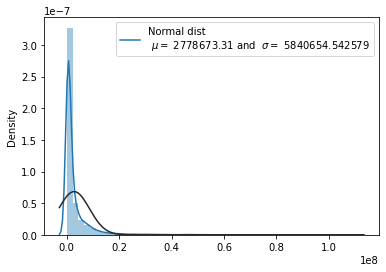

In [136]:
sns.distplot(y_train.values,fit=norm)
(mu,sigma)=norm.fit(fifa_train['value'])
plt.legend(['Normal dist \n $\mu=$ {:.2f} and  $\sigma=$ {:2f}'.format(mu,sigma)],loc='best')

C:\Users\chddh\.conda\envs\ML\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


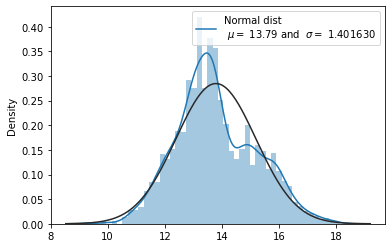

In [137]:
sns.distplot(np.log1p(y_train.values),fit=norm)
(mu,sigma)=norm.fit(np.log1p(fifa_train['value']))
plt.legend(['Normal dist \n $\mu=$ {:.2f} and  $\sigma=$ {:2f}'.format(mu,sigma)],loc='best')

In [138]:
# log 변환, 정규 분포
y_train=np.log1p(fifa_train['value'])

In [139]:
X_train.head()

,age,contract_until,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,continent_africa,continent_asia,continent_europe,continent_oceania,continent_south america,position_DF,position_GK,position_MF,position_ST
0,31,3,False,5.0,94,94,4.0,0,0,0,0,1,0,0,0,1
1,27,2,True,4.0,91,93,1.0,0,0,1,0,0,0,1,0,0
2,31,3,True,5.0,91,91,3.0,0,0,0,0,1,0,0,0,1
3,32,2,True,4.0,91,91,3.0,0,0,1,0,0,1,0,0,0
4,25,3,True,3.0,90,93,1.0,0,0,1,0,0,0,1,0,0


In [140]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8932 entries, 0 to 8931
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age                      8932 non-null   int64  
 1   contract_until           8932 non-null   int64  
 2   prefer_foot              8932 non-null   bool   
 3   reputation               8932 non-null   float64
 4   stat_overall             8932 non-null   int64  
 5   stat_potential           8932 non-null   int64  
 6   stat_skill_moves         8932 non-null   float64
 7   continent_africa         8932 non-null   uint8  
 8   continent_asia           8932 non-null   uint8  
 9   continent_europe         8932 non-null   uint8  
 10  continent_oceania        8932 non-null   uint8  
 11  continent_south america  8932 non-null   uint8  
 12  position_DF              8932 non-null   uint8  
 13  position_GK              8932 non-null   uint8  
 14  position_MF             

In [141]:
# 1차 시도했던 내용. 추천 코드로 수정중

# from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
# from sklearn.model_selection import GridSearchCV
# params={
#     'n_estimators':[100,200,300],'max_depth':[8,10,12,14,16],'min_samples_leaf':[3,4,6,8,12,18],
#     'min_samples_split':[4,6,8,16,20,24]
# }
# gbm_reg=GradientBoostingRegressor()
# params={'max_depth':[4,6,8],'n_estimators':[100,200],'learning_rate':[0.05,0.1]}
# grid_cv=GridSearchCV(gbm_reg,param_grid=params,scoring = 'neg_mean_squared_error',cv=3,verbose=1)
# X_train.shape,y_train.shape
# grid_cv.fit(X_train,y_train)
# grid_cv.best_params_
# from sklearn.metrics import mean_squared_error
# y_train_GB_predict=grid_cv.best_estimator_.predict(X_train_scaled)
# y_test_GB_predict=grid_cv.best_estimator_.predict(X_test)
# y_test_GB_predict=y_test_GB_predict
# print(y_test_GB_predict[:5])
# np.sqrt(mean_squared_error(y_train_GB_predict,y_train))
# submission=pd.read_csv('submission.csv')
# submission['value']=np.expm1(y_test_GB_predict)
# submission.to_csv('submission_GB.csv',index=False)

In [142]:
scaler=StandardScaler()
X_train=pd.DataFrame(scaler.fit_transform(X_train),columns=X_train.columns)

X_test=pd.DataFrame(scaler.fit_transform(X_test),columns=X_test.columns)

In [143]:
pbound= { 'learning_rate':(0.0001,0.4),
         'n_estimators':(16,1024),
         'max_depth':(3,10),
         'subsample':(0.5,1),
         'colsample_bytree':(0.5,1),
         'gamma':(0,5)

}

def xgb_opt(learning_rate,n_estimators,max_depth,subsample,colsample_bytree,gamma):
    params={
        'learning_rate':learning_rate,
        'n_estimators':int(round(n_estimators)),
         'max_depth':int(round(max_depth)),
        'subsample':subsample,
        'colsample_bytree':colsample_bytree,
        'gamma':gamma,
        'n_jobs':-1,
        'random_state':777
    }
    xgb=XGBRegressor(**params)
    kf=KFold(n_splits=4,shuffle=True,random_state=50)
    score=cross_val_score(xgb,X_train,y_train,scoring='neg_mean_squared_error',cv=kf,n_jobs=-1)
    return np.mean(score)
BO_xgb=BayesianOptimization(f=xgb_opt,pbounds=pbound,random_state=0)

In [144]:
BO_xgb.maximize(init_points=10,n_iter=200)

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | n_esti... | subsample |
-------------------------------------------------------------------------------------------------
|  1        | -0.02071  |  0.7744   |  3.576    |  0.2411   |  6.814    |  443.0    |  0.8229   |
|  2        | -0.0277   |  0.7188   |  4.459    |  0.3855   |  5.684    |  814.1    |  0.7644   |
|  3        | -22.47    |  0.784    |  4.628    |  0.02851  |  3.61     |  36.38    |  0.9163   |
|  4        | -0.02436  |  0.8891   |  4.35     |  0.3914   |  8.594    |  481.2    |  0.8903   |
|  5        | -0.01882  |  0.5591   |  3.2      |  0.05743  |  9.613    |  542.0    |  0.7073   |
|  6        | -0.02261  |  0.6323   |  3.871    |  0.1825   |  6.979    |  34.94    |  0.8088   |
|  7        | -0.02258  |  0.806    |  3.085    |  0.3775   |  7.773    |  378.4    |  0.7185   |
|  8        | -0.009731 |  0.8488   |  0.3011   |  0.2667   |  7.694    |  228.1    |  0.5645   |
|  9        | -0.016

In [145]:
BO_xgb.max

{'target': -0.004604247839145183,
 'params': {'colsample_bytree': 1.0,
  'gamma': 0.0,
  'learning_rate': 0.4,
  'max_depth': 3.0,
  'n_estimators': 1012.5538870504954,
  'subsample': 1.0}}

In [146]:
params=BO_xgb.max['params']
params['max_depth']=int(round(params['max_depth']))
params['n_estimators']=int(round(params['n_estimators']))
xgb=XGBRegressor(random_state=777,**params)
xgb.fit(X_train,y_train)

C:\Users\chddh\.conda\envs\ML\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1.0, enable_categorical=False,
             gamma=0.0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.4, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1013, n_jobs=16,
             num_parallel_tree=1, predictor='auto', random_state=777,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1.0,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [147]:
pred_xgb=np.expm1(xgb.predict(X_test))

In [148]:
pbound={'learning_rate':(0.0005,0.2),
        'n_estimators':(16,1024),
        'max_depth':(3,10),
        'subsample':(0.5,1),
        'colsample_bytree':(0.5,1),
        'num_leaves':(2,16),
        'min_child_weight':(1,10)
        

}

def lgbm_opt( learning_rate,n_estimators,max_depth,subsample,colsample_bytree,num_leaves,min_child_weight ):
    params ={
        'learning_rate':learning_rate,
        'n_estimators':int(round(n_estimators)),
        'max_depth':int(round(max_depth)),
        'subsample':subsample,
        'colsample_bytree':colsample_bytree,
        'num_leaves':int(round(num_leaves)),
        'min_child_weight':min_child_weight,
        'n_jobs':-1
    }
    lgbm=LGBMRegressor(**params)
    kf=KFold(n_splits=4,shuffle=True,random_state=50)
    score=cross_val_score(lgbm,X_train,y_train,scoring='neg_mean_squared_error',cv=kf,n_jobs=-1)
    return np.mean(score)
BO_lgbm=BayesianOptimization(f=lgbm_opt,pbounds=pbound,random_state=1)


In [149]:
BO_lgbm.maximize(init_points=10,n_iter=200)

|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | n_esti... | num_le... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        | -0.009167 |  0.7085   |  0.1442   |  3.001    |  3.721    |  163.9    |  3.293    |  0.5931   |
|  2        | -0.005619 |  0.6728   |  0.07966  |  6.772    |  4.773    |  706.7    |  4.862    |  0.9391   |
|  3        | -0.008043 |  0.5137   |  0.1343   |  5.921    |  6.028    |  157.5    |  4.773    |  0.9004   |
|  4        | -0.006434 |  0.9841   |  0.06303  |  7.846    |  8.888    |  917.8    |  3.191    |  0.5195   |
|  5        | -0.004705 |  0.5849   |  0.1757   |  3.688    |  4.79     |  981.6    |  9.464    |  0.8459   |
|  6        | -0.004762 |  0.6578   |  0.1375   |  8.842    |  1.165    |  772.1    |  15.84    |  0.8741   |
|  7        | -0.00486  |  0.6402   |  0.158    |  3.723    |  5.031    |  931.9    |  6.111    |  0.6439   |
|  8      

In [150]:
BO_lgbm.max

{'target': -0.004638046138433782,
 'params': {'colsample_bytree': 0.6309113072395951,
  'learning_rate': 0.1682913180415569,
  'max_depth': 8.458916123240563,
  'min_child_weight': 4.090163058227916,
  'n_estimators': 722.7129747608805,
  'num_leaves': 10.754863841373055,
  'subsample': 0.5383135732602176}}

In [151]:
params=BO_lgbm.max['params']
params['max_depth']=int(round(params['max_depth']))
params['n_estimators']=int(round(params['n_estimators']))
params['num_leaves']=int(round(params['num_leaves']))

In [152]:
lgbm=LGBMRegressor(seed=1011,**params)

In [153]:
lgbm.fit(X_train,y_train)

LGBMRegressor(colsample_bytree=0.6309113072395951,
              learning_rate=0.1682913180415569, max_depth=8,
              min_child_weight=4.090163058227916, n_estimators=723,
              num_leaves=11, seed=1011, subsample=0.5383135732602176)

In [154]:
pred_lgbm=np.expm1(lgbm.predict(X_test))

In [155]:
pbounds = { 'learning_rate': (0.0005, 0.2),
            'n_estimators': (16, 512),
            'max_depth': (3,10),   
            'subsample': (0.5,1), 
            'min_samples_split': (2,5),   
            'min_samples_leaf': (1,5)}

def gbm_opt(learning_rate, n_estimators, max_depth, subsample, min_samples_split, min_samples_leaf):

    params = {
        'learning_rate': learning_rate,
        'n_estimators' : int(round(n_estimators)),
        'max_depth' : int(round(max_depth)),
        'subsample': subsample,
        'min_samples_split' : int(round(min_samples_split)),
        'min_samples_leaf' : int(round(min_samples_leaf))
    }
    
    gbm = GradientBoostingRegressor(**params)
    kf = KFold(n_splits = 4 , shuffle = True, random_state=50)
    score = cross_val_score(gbm, X_train, y_train, scoring='neg_mean_squared_error', cv = kf, n_jobs=-1)
    return np.mean(score)

BO_gbm = BayesianOptimization(f = gbm_opt, pbounds = pbounds, random_state=0)    

In [156]:

BO_gbm.maximize(init_points = 10, n_iter = 200)

|   iter    |  target   | learni... | max_depth | min_sa... | min_sa... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------
|  1        | -0.006594 |  0.11     |  8.006    |  3.411    |  3.635    |  226.1    |  0.8229   |
|  2        | -0.006475 |  0.0878   |  9.242    |  4.855    |  3.15     |  408.7    |  0.7644   |
|  3        | -0.0118   |  0.1138   |  9.479    |  1.284    |  2.261    |  26.03    |  0.9163   |
|  4        | -0.007073 |  0.1557   |  9.09     |  4.914    |  4.397    |  244.9    |  0.8903   |
|  5        | -0.005708 |  0.0241   |  7.479    |  1.573    |  4.834    |  274.8    |  0.7073   |
|  6        | -0.1412   |  0.05328  |  8.42     |  2.825    |  3.705    |  25.32    |  0.8088   |
|  7        | -0.005686 |  0.1226   |  7.319    |  4.775    |  4.045    |  194.3    |  0.7185   |
|  8        | -0.007524 |  0.1397   |  3.422    |  3.667    |  4.012    |  120.3    |  0.5645   |
|  9        | -0.005

In [157]:
BO_gbm.max

{'target': -0.004564337530219787,
 'params': {'learning_rate': 0.0950546688545846,
  'max_depth': 4.36894961073741,
  'min_samples_leaf': 1.3272193335135354,
  'min_samples_split': 4.865059071906579,
  'n_estimators': 469.4347022714532,
  'subsample': 0.623483640388429}}

In [158]:
params=BO_gbm.max['params']
params['max_depth']=int(round(params['max_depth']))
params['n_estimators']=int(round(params['n_estimators']))
params['min_samples_leaf']=int(round(params['min_samples_leaf']))
params['min_samples_split']=int(round(params['min_samples_split']))

In [159]:
gbm=GradientBoostingRegressor(random_state=123,**params)
gbm.fit(X_train,y_train)
pred_gbm=np.expm1(gbm.predict(X_test))

In [160]:
vot=VotingRegressor(estimators=[('lgbm',lgbm),('xgb',xgb),('gbm',gbm)],weights=(0.4,0.4,0.2))

In [161]:
vot.fit(X_train,y_train)

C:\Users\chddh\.conda\envs\ML\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


VotingRegressor(estimators=[('lgbm',
                             LGBMRegressor(colsample_bytree=0.6309113072395951,
                                           learning_rate=0.1682913180415569,
                                           max_depth=8,
                                           min_child_weight=4.090163058227916,
                                           n_estimators=723, num_leaves=11,
                                           seed=1011,
                                           subsample=0.5383135732602176)),
                            ('xgb',
                             XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1.0,...
                                          num_parallel_tree=1, predictor='auto',
                                          random_state=777, reg_alpha=0,
        

In [162]:
pred_vot=np.expm1(vot.predict(X_test))

In [163]:
submission=pd.read_csv('submission.csv')

In [164]:
submission['value']=(pred_gbm+pred_xgb+pred_lgbm+pred_vot)/4

In [165]:
# q1=submission['value'].quantile(0.0042)
# q2=submission['value'].quantile(0.99)
# submission['value']=submission['value'].apply(lambda x:x if x>q1 else x*0.77)
# submission['value']=submission['value'].apply(lambda x:x if x<q2 else x*1.1)

In [166]:
submission

,id,value
0,1,5.189290e+07
1,2,8.928842e+07
2,4,8.185342e+07
3,5,8.420668e+07
4,6,6.062026e+07
...,...,...
3823,16924,5.833165e+04
3824,16929,5.147319e+04
3825,16932,5.989605e+04
3826,16937,4.970408e+04


In [167]:
submission.to_csv('sub220427.csv',index=False)

In [169]:
submission['value']=pred_lgbm
submission.to_csv('sub_lgbm.csv',index=False)

In [168]:
# from sklearn.preprocessing import StandardScaler
# scaler=StandardScaler()

# scaler.fit(X_train)
# X_train_scaled=scaler.transform(X_train)
# X_test_scaled=scaler.transform(X_test)
# from sklearn.linear_model import Ridge
# from sklearn.metrics import mean_squared_error
# ridge=Ridge(alpha=1)
# X_train=X_train.values
# y_train=y_train.values
# X_test=X_test.values
# ridge.fit(X_train_scaled,y_train)
# y_train_predict=ridge.predict(X_train)
# mse=mean_squared_error(y_train,y_train_predict)
# rmse=np.sqrt(mse)
# print(rmse)
# y_test_predict=ridge.predict(X_test)
# submission['value']=np.expm1(y_test_predict)
# submission.to_csv('submission_Ridge.csv',index=False)